In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
import torch
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader
from Source.Util.simulateToyData import ToySimulator

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runpath = "runs/set5_2jet_small/"

# Load data

In [3]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

In [4]:
data_raw = np.load("../data/Z_2.npy")
data_raw = prep.preformat(data_raw, params)
n_gauss = params["n_gauss"]
channels = params["channels"]
data, data_mean, data_std, data_u, data_s, bin_edges, bin_means = prep.preprocess(data_raw, params)

# Initialize modified model class

In [5]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)
model.eval()

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=32, n_blocks=6, intermediate_fac=4, n_gauss=30
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


AutoRegGMM(
  (net): attnetGMM(
    (transformer): ModuleDict(
      (wte): Linear(in_features=1, out_features=128, bias=True)
      (wpe): Embedding(13, 128)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): TransformerBlock(
          (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=128, out_features=384, bias=True)
            (c_proj): Linear(in_features=128, out_features=128, bias=True)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): ModuleDict(
            (c_fc): Linear(in_features=128, out_features=512, bias=True)
            (c_proj): Linear(in_features=512, out_features=128, bias=True)
            (act): NewGELU()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )


In [6]:
data_split = params["data_split"]
n_data = len(data)
cut1 = int(n_data - data_split[0])
model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)

# Generate samples

In [7]:
n_samples = 10
samples, xs, probs, probsindiv = model.sample_n_bonus(n_samples)
samples = samples[:,1:]

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


# Test plot

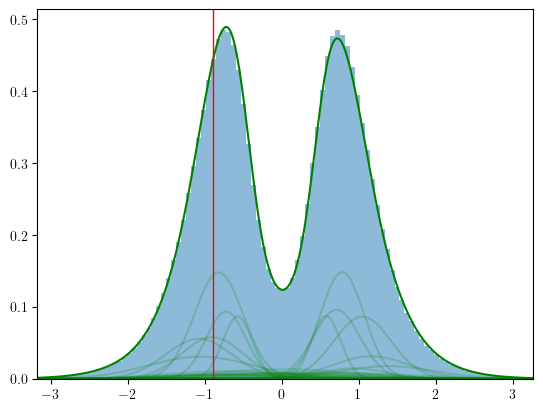

In [8]:
idim=0
isample=0
bins=100
xmin=np.min(xs[idim,:])
xmax=np.max(xs[idim,:])
plt.hist(data[:,idim], alpha=.5, bins=bins, range=(xmin, xmax), density=True, align="mid", rwidth=1.)
plt.plot(xs[idim,:], probs[isample, idim, :], color="g")
for igauss in range(n_gauss):
    plt.plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", linestyle="-", alpha=.2)
_, ymax = plt.ylim()
plt.vlines(samples[isample,idim], 0., ymax, "r", linewidth=1)
plt.xlim(xmin, xmax)
plt.ylim(0., ymax)
plt.show()

In [9]:
n_samples = 10000
samples = model.sample_n(n_samples)
samples_raw = prep.undo_preprocessing(samples, data_mean, data_std, 
                                      data_u, data_s, bin_means, 
                                      bin_edges, params)

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Sampling time estimate: 24.53 s = 0.41 min


# $\Delta R$ marginalized likelihood with grid integration

In [10]:
def marginalize(x, likelihood, dim):
    likelihood2 = np.swapaxes(likelihood, dim, 0)
    marg = np.trapz(likelihood2, x=x, axis=0)
    return marg

How to preprocess on pdf level

- Standardization: gauss() and inversegauss() (derive this with transformation method?)
- artanh: Derive with transformation method

Challenge: How to preprocess $\Delta R$?

In [15]:
precR = 100
precM = 60
batch_size = 2048
dRmin0 = 0.
dRmax0 = 8.
dRmin = 0.
dRmax = 8.
dR0 = np.linspace(dRmin, dRmax, precR)
phimin = -np.pi +1e-2
phimax = np.pi -1e-2
etamin = -5.
etamax = 5.
phi0 = np.linspace(phimin, phimax, precM)
eta0 = np.linspace(etamin, etamax, precM)
phi1, eta1, phi2 = np.meshgrid(phi0, eta0, phi0)
x0 = torch.ones(precM**3) * 2
x1 = (np.arctanh(phi1 / np.pi) - data_mean[0,0]) / data_std[0,0]
x2 = (eta1 - data_mean[0,1]) / data_std[0,1]
x3 = (np.arctanh(phi2 / np.pi) - data_mean[0,2]) / data_std[0,2]
base = np.stack([x0.ravel(), x1.ravel(), x2.ravel(), x3.ravel()], -1)
loader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
likelihood_tot = np.zeros((0, precR))
for batch_id, x in enumerate(loader):
    # build GMM
    t0 = time.time()
    _, _, mu, sigma, weights = model.batch_loss(x.float(), getMore=True)
    gmm = D.MixtureSameFamily(D.Categorical(weights), D.Normal(mu, sigma))
    
    # undo preprocessing
    phi1 = torch.tanh( data_std[0,0]*x[:,1] + data_mean[0,0]) *np.pi
    eta1 = data_std[0,1]*x[:,2] + data_mean[0,1]
    phi2 = torch.tanh( data_std[0,2]*x[:,3] + data_mean[0,2]) *np.pi
    
    # compute possible eta2 values
    likelihood_tot0 = torch.zeros((x.size(0), 0))
    for i in range(precR):
        eta2 = eta1 - (dR0[i]**2 - (phi1-phi2)**2)**.5
        eta2 = torch.nan_to_num(eta2, nan=-10.)
        x4 = (eta2 - data_mean[0,3]) / data_std[0,3]
    
        xFull = torch.stack([x[:,1], x[:,2], x[:,3], x4], -1)
        likelihood = torch.exp(torch.sum(gmm.log_prob(xFull), dim=-1))
        
        facPrep1 = np.pi/(np.pi**2- phi1**2) * np.pi/(np.pi**2- phi2**2) #coordinate transformation in preprocess=1
        facPrep2 = 1/(data_std[0,0] * data_std[0,1] * data_std[0,2] * data_std[0,3]) #coordinate transformation in preprocess=2
        facdR = 2 * dR0[i] / (dR0[i]**2 - (phi1 - phi2)**2)**.5
        likelihood = likelihood * facPrep1 * facPrep2 * facdR
        likelihood = torch.nan_to_num(likelihood, nan=0.) #set the same to zero as above
        
        likelihood0 = torch.zeros((x.size(0), 1))
        likelihood0[:,0] = likelihood
        likelihood_tot0 = np.append(likelihood_tot0, likelihood0.detach().cpu().numpy(), axis=1)
    likelihood_tot = np.append(likelihood_tot, likelihood_tot0, axis=0)
    
    if batch_id == 0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*(precM**3//batch_size)/60:.2f} min")

Estimate: 0.80 min


In [16]:
likelihoodArr = likelihood_tot.reshape(precM, precM, precM, precR)

In [17]:
print(np.sum([likelihood_tot < 1e-50])) #where are the nans? something with triangles...
print(np.shape(likelihood_tot.reshape(-1)))

5782080
(21600000,)


In [18]:
marginaldR = likelihoodArr
marginaldR = marginalize(phi0, marginaldR, 0)
marginaldR = marginalize(eta0, marginaldR, 0)
marginaldR = marginalize(phi0, marginaldR, 0)
normdR = marginalize(dR0, marginaldR, 0)
print(f"Check: normalization = {normdR:.10f}")

Check: normalization = 0.9976637914


NameError: name 'samples_raw' is not defined

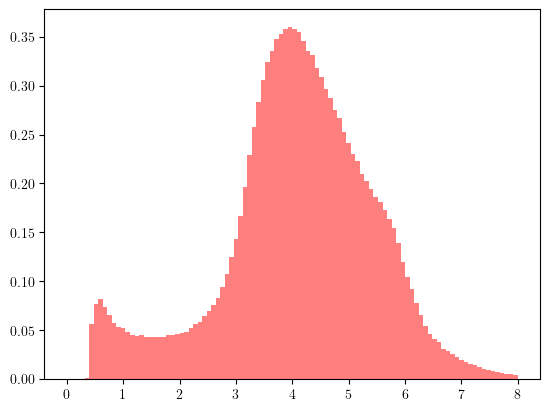

In [19]:
def dR(data):
    return ((data[:,9]-data[:,13])**2 + (data[:,10]-data[:,14])**2)**.5
nbins=100
plt.hist(dR(data_raw), range=(dRmin0, dRmax0), bins=nbins, alpha=.5, density=True, color="r", label="truth")
plt.hist(dR(samples_raw), range=(dRmin0, dRmax0), bins=nbins, alpha=.5, density=True, color="b", label="model")
plt.plot(dR0, marginaldR, color="b", label="model likelihood")
ymin, ymax = plt.ylim()
plt.vlines(.4, ymin, ymax, color="k", linestyle="--", alpha=.5)
plt.xlim(dRmin, dRmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.savefig("marginaldR.pdf", bbox_inches="tight")
plt.show()

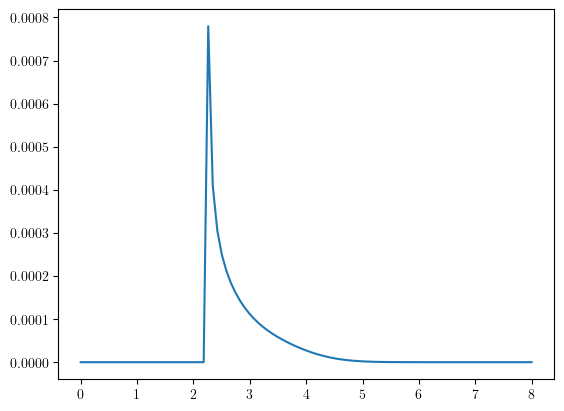

In [14]:
# have weird peaks - but why?
plt.plot(dR0, likelihoodArr[24,32,53,:])
plt.savefig("dR_weird.pdf")
plt.show()

# $\Delta R$ marginalized likelihood with MC integration

In [41]:
prec = 100
batch_size = 1024
dRmin = .2
dRmax = 1.5
dR0 = np.linspace(dRmin, dRmax, prec)
etamin = -5.
etamax = 5.
phimin = -np.pi + 1.e-2
phimax = np.pi - 1.e-2

N = 20000 #100000
Ntry = N * 10

def getMarginalLikelihood(dRval, N, out=False):
    Nact = 0
    base = np.zeros((0, 5))
    accRate = np.zeros(0)
    while Nact<N:
        phi1 = np.random.uniform(low=phimin, high=phimax, size=Ntry)
        phi2 = np.random.uniform(low=phimin, high=phimax, size=Ntry)
        eta1 = np.random.uniform(low=etamin, high=etamax, size=Ntry)
        eta2 = eta1 - (dRval**2 - (phi1-phi2)**2)**.5
        idx = np.where(np.invert(np.isnan(eta2)))
        Nidx = np.shape(idx)[1]
        accRate = np.append(accRate, Nidx/Ntry)
        phi1, phi2, eta1, eta2 = phi1[idx], phi2[idx], eta1[idx], eta2[idx]
        Nact += Nidx
        
        x1 = (np.arctanh(phi1 / np.pi) - data_mean[0,0]) / data_std[0,0]
        x2 = (eta1 - data_mean[0,1]) / data_std[0,1]
        x3 = (np.arctanh(phi2 / np.pi) - data_mean[0,2]) / data_std[0,2]
        x4 = (eta2 - data_mean[0,3]) / data_std[0,3]
        
        facPrep1 = np.pi/(np.pi**2- phi1**2) * np.pi/(np.pi**2- phi2**2) #coordinate transformation in preprocess=1
        facPrep2 = 1/(data_std[0,0] * data_std[0,1] * data_std[0,2] * data_std[0,3]) #coordinate transformation in preprocess=2
        facdR = 2 * dRval / (dRval**2 - (phi1 - phi2)**2)**.5
        jacFac = facPrep1 * facPrep2 * facdR
        
        base = np.append(base, np.stack([x1, x2, x3, x4, jacFac], -1), axis=0)
    accRate = np.mean(accRate)
    base = base[:N, :]

    cartesianLoader = torch.utils.data.DataLoader(dataset=base, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    likelihood = np.zeros(0)
    for batch_id, x in enumerate(cartesianLoader):
        t0 = time.time()
        x0 = x[:,:4].float()
        _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
        likelihood0 *= x[:,4]
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
        if batch_id == 0 and out:
            t1 = time.time()
            print(f"Estimate: {(t1-t0)*(N//batch_size):.2f} s = {(t1-t0)*(N//batch_size)/60:.2f} min")
    likelihood_mean = np.mean(likelihood)
    V = (phimax-phimin)**2 * (etamax-etamin) * accRate
    I_mean = V * likelihood_mean
    I_variance = V /N**.5 * (1/(N-1) * np.sum((likelihood-likelihood_mean)**2))**.5
    return I_mean, I_variance
    
marg, marg_err = np.zeros((2, prec))
for i in range(prec):
    t0 = time.time()
    print(f"{i:>3}/{prec}", end="\r")
    marg[i], marg_err[i] = getMarginalLikelihood(dR0[i], N)
    if i==0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*prec:.2f} s = {(t1-t0)*prec/60:.2f} min")

/tmp/ipykernel_3111/3302247728.py:22: RuntimeWarning: invalid value encountered in sqrt
  eta2 = eta1 - (dRval**2 - (phi1-phi2)**2)**.5


Estimate: 219.68 s = 3.66 min


In [32]:
# find uncertainty dynamically (not good)
prec = 100
batch_size = 1024
dRmin = .2
dRmax = 8.
dR0 = np.linspace(dRmin, dRmax, prec)
etamin = -5.
etamax = 5.
phimin = -np.pi + 1.e-2
phimax = np.pi - 1.e-2

std_goal = .01
N = batch_size * 5
Ntry = N * 10
itry_max = 20

def getMarginalLikelihood(dRval, N, out=False):
    I_mean, I_std = 0., 1.
    Nact = 0
    base = np.zeros((0, 5))
    accRate = np.zeros(0)
    likelihood = np.zeros(0)
    itry = 1
    while I_std > std_goal:
        #generate samples
        while Nact<N:
            phi1 = np.random.uniform(low=phimin, high=phimax, size=Ntry)
            phi2 = np.random.uniform(low=phimin, high=phimax, size=Ntry)
            eta1 = np.random.uniform(low=etamin, high=etamax, size=Ntry)
            eta2 = eta1 - (dRval**2 - (phi1-phi2)**2)**.5
            idx = np.where(np.invert(np.isnan(eta2)))
            Nidx = np.shape(idx)[1]
            accRate = np.append(accRate, Nidx/Ntry)
            phi1, phi2, eta1, eta2 = phi1[idx], phi2[idx], eta1[idx], eta2[idx]
            Nact += Nidx
        
            x1 = (np.arctanh(phi1 / np.pi) - data_mean[0,0]) / data_std[0,0]
            x2 = (eta1 - data_mean[0,1]) / data_std[0,1]
            x3 = (np.arctanh(phi2 / np.pi) - data_mean[0,2]) / data_std[0,2]
            x4 = (eta2 - data_mean[0,3]) / data_std[0,3]
        
            facPrep1 = np.pi/(np.pi**2- phi1**2) * np.pi/(np.pi**2- phi2**2) #coordinate transformation in preprocess=1
            facPrep2 = 1/(data_std[0,0] * data_std[0,1] * data_std[0,2] * data_std[0,3]) #coordinate transformation in preprocess=2
            facdR = 2 * dRval / (dRval**2 - (phi1 - phi2)**2)**.5
            jacFac = facPrep1 * facPrep2 * facdR
        
            base = np.append(base, np.stack([x1, x2, x3, x4, jacFac], -1), axis=0)
        base = base[:N, :]
        
        #evaluate likelihood
        x = torch.from_numpy(base)
        x0 = x[:,:4].float()
        _, likelihood0, _, _, _ = model.batch_loss(x0, getMore=True)
        likelihood0 *= x[:,4]
        likelihood0 = likelihood0.detach().numpy()
        likelihood = np.append(likelihood, likelihood0)
    
        #evaluate integral
        likelihood_mean = np.mean(likelihood)
        V = (phimax-phimin)**2 * (etamax-etamin) * np.mean(accRate)
        I_mean = V * likelihood_mean
        I_std = V /(N*itry)**.5 * (1/(N*itry-1) * np.sum((likelihood-likelihood_mean)**2))**.5
        print(f"{dRval:.2f} - Achieved std={I_std:.2e} after {itry} runs", np.shape(likelihood))
        
        itry+=1
        if itry>itry_max:
            break
    return I_mean, I_std
    
marg, marg_err = np.zeros((2, prec))
for i in range(prec):
    t0 = time.time()
    print(f"{i:>3}/{prec}", end="\r")
    marg[i], marg_err[i] = getMarginalLikelihood(dR0[i], N)
    if i==0:
        t1 = time.time()
        print(f"Estimate: {(t1-t0)*prec:.2f} s = {(t1-t0)*prec/60:.2f} min")

/tmp/ipykernel_3111/2145692193.py:29: RuntimeWarning: invalid value encountered in sqrt
  eta2 = eta1 - (dRval**2 - (phi1-phi2)**2)**.5


0.20 - Achieved std=3.46e-05 after 1 runs (5120,)
Estimate: 54.37 s = 0.91 min
0.28 - Achieved std=1.47e-04 after 1 runs (5120,)
0.36 - Achieved std=6.19e-03 after 1 runs (5120,)
0.44 - Achieved std=1.80e-03 after 1 runs (5120,)
0.52 - Achieved std=5.52e-03 after 1 runs (5120,)
0.59 - Achieved std=3.26e-03 after 1 runs (5120,)
0.67 - Achieved std=2.25e-03 after 1 runs (5120,)
0.75 - Achieved std=6.97e-03 after 1 runs (5120,)
0.83 - Achieved std=3.70e-03 after 1 runs (5120,)
0.91 - Achieved std=2.17e-03 after 1 runs (5120,)
0.99 - Achieved std=1.97e-03 after 1 runs (5120,)
1.07 - Achieved std=1.90e-03 after 1 runs (5120,)
1.15 - Achieved std=1.78e-03 after 1 runs (5120,)
1.22 - Achieved std=7.51e-03 after 1 runs (5120,)
1.30 - Achieved std=1.92e-03 after 1 runs (5120,)
1.38 - Achieved std=1.58e-03 after 1 runs (5120,)
1.46 - Achieved std=1.78e-03 after 1 runs (5120,)
1.54 - Achieved std=1.48e-03 after 1 runs (5120,)
1.62 - Achieved std=1.88e-03 after 1 runs (5120,)
1.70 - Achieved std=1

4.69 - Achieved std=1.87e-02 after 1 runs (5120,)
4.69 - Achieved std=1.33e-02 after 2 runs (10240,)
4.69 - Achieved std=1.08e-02 after 3 runs (15360,)
4.69 - Achieved std=9.37e-03 after 4 runs (20480,)
4.77 - Achieved std=1.77e-02 after 1 runs (5120,)
4.77 - Achieved std=1.26e-02 after 2 runs (10240,)
4.77 - Achieved std=1.02e-02 after 3 runs (15360,)
4.77 - Achieved std=8.87e-03 after 4 runs (20480,)
4.85 - Achieved std=1.95e-02 after 1 runs (5120,)
4.85 - Achieved std=1.38e-02 after 2 runs (10240,)
4.85 - Achieved std=1.13e-02 after 3 runs (15360,)
4.85 - Achieved std=9.77e-03 after 4 runs (20480,)
4.93 - Achieved std=1.29e-02 after 1 runs (5120,)
4.93 - Achieved std=9.13e-03 after 2 runs (10240,)
5.01 - Achieved std=1.81e-02 after 1 runs (5120,)
5.01 - Achieved std=1.28e-02 after 2 runs (10240,)
5.01 - Achieved std=1.04e-02 after 3 runs (15360,)
5.01 - Achieved std=9.03e-03 after 4 runs (20480,)
5.08 - Achieved std=1.91e-02 after 1 runs (5120,)
5.08 - Achieved std=1.35e-02 after 2 

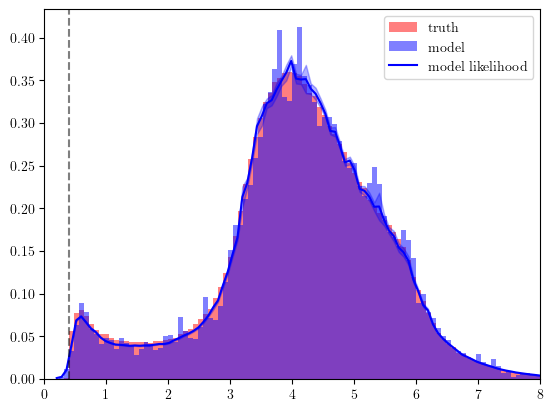

In [36]:
def dR(data):
    return ((data[:,9]-data[:,13])**2 + (data[:,10]-data[:,14])**2)**.5
nbins=100
dRmin0 = 0.
dRmax0 = 8.
plt.hist(dR(data_raw), range=(dRmin0, dRmax0), bins=nbins, alpha=.5, density=True, color="r", label="truth")
plt.hist(dR(samples_raw), range=(dRmin0, dRmax0), bins=nbins, alpha=.5, density=True, color="b", label="model")
plt.plot(dR0, marg, color="b", label="model likelihood")
plt.fill_between(dR0, marg+marg_err, marg-marg_err, color="b", alpha=.3)
ymin, ymax = plt.ylim()
plt.vlines(.4, ymin, ymax, color="k", linestyle="--", alpha=.5)
plt.xlim(dRmin0, dRmax0)
plt.ylim(ymin, ymax)
plt.legend()
plt.savefig("marginaldR_test.pdf", bbox_inches="tight")
plt.show()

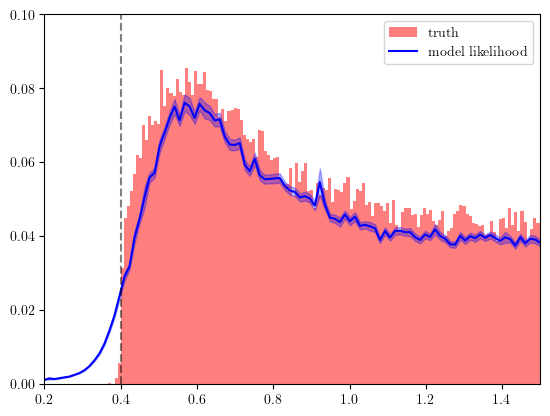

In [55]:
nbins=1000
dRmin0 = 0.2
dRmax0 = 1.5 
plt.hist(dR(data_raw), range=(0., 8.), bins=nbins, alpha=.5, density=True, color="r", label="truth")
#plt.hist(dR(samples_raw), range=(dRmin0, dRmax0), bins=nbins, alpha=.5, density=True, color="b", label="model")
plt.plot(dR0, marg, color="b", label="model likelihood")
plt.fill_between(dR0, marg+marg_err, marg-marg_err, color="b", alpha=.3)
plt.ylim(0., .1)
ymin, ymax = plt.ylim()
plt.vlines(.4, ymin, ymax, color="k", linestyle="--", alpha=.5)
plt.xlim(dRmin0, dRmax0)
plt.ylim(ymin, ymax)
plt.legend()
plt.savefig("marginaldR_test.pdf", bbox_inches="tight")
plt.show()

In [37]:
print(marg)
print(marg_err)

[0.00110622 0.00249513 0.01077432 0.03930907 0.06880746 0.07335197
 0.06640691 0.05919935 0.05489723 0.04855242 0.04447659 0.0421921
 0.04037873 0.04002671 0.03952694 0.03890121 0.03928965 0.03894748
 0.03933552 0.03935045 0.0401935  0.04099793 0.04100716 0.04224656
 0.04540579 0.04790616 0.05084258 0.05325258 0.05635198 0.06037558
 0.06665337 0.07386631 0.08355381 0.09187939 0.10928812 0.12549077
 0.14615331 0.16569823 0.21330195 0.22963743 0.25906133 0.29623736
 0.3081238  0.32302838 0.32663438 0.33889228 0.34926719 0.35905069
 0.37261745 0.35187959 0.3508659  0.35138154 0.34011544 0.33413806
 0.32337105 0.31065188 0.29062799 0.2896049  0.27292745 0.25389705
 0.25589252 0.24432354 0.22276105 0.22047335 0.21346858 0.20175014
 0.20211907 0.18661997 0.17408614 0.1673777  0.15405425 0.14840876
 0.13851344 0.11648674 0.10304941 0.0866805  0.08035097 0.06433878
 0.05414057 0.04764373 0.04223831 0.03771079 0.03314597 0.028527
 0.0259455  0.02322016 0.02030563 0.01820818 0.0163371  0.0145467

In [44]:
print(dR0)

[0.2        0.21313131 0.22626263 0.23939394 0.25252525 0.26565657
 0.27878788 0.29191919 0.30505051 0.31818182 0.33131313 0.34444444
 0.35757576 0.37070707 0.38383838 0.3969697  0.41010101 0.42323232
 0.43636364 0.44949495 0.46262626 0.47575758 0.48888889 0.5020202
 0.51515152 0.52828283 0.54141414 0.55454545 0.56767677 0.58080808
 0.59393939 0.60707071 0.62020202 0.63333333 0.64646465 0.65959596
 0.67272727 0.68585859 0.6989899  0.71212121 0.72525253 0.73838384
 0.75151515 0.76464646 0.77777778 0.79090909 0.8040404  0.81717172
 0.83030303 0.84343434 0.85656566 0.86969697 0.88282828 0.8959596
 0.90909091 0.92222222 0.93535354 0.94848485 0.96161616 0.97474747
 0.98787879 1.0010101  1.01414141 1.02727273 1.04040404 1.05353535
 1.06666667 1.07979798 1.09292929 1.10606061 1.11919192 1.13232323
 1.14545455 1.15858586 1.17171717 1.18484848 1.1979798  1.21111111
 1.22424242 1.23737374 1.25050505 1.26363636 1.27676768 1.28989899
 1.3030303  1.31616162 1.32929293 1.34242424 1.35555556 1.368686